# Hessian & batch executation

This example shows how to obtan hessian and how to perform batch executation. Since functorch functions (vmap, hessian, jacfwd, etc.) currently do not support the use of autograd.Function. Hessian & batch executation function are only supported by PyTorch backend backpropagation autograd method now.

# Initialization

In [1]:
import tedq as qai
import torch
from functorch import hessian, jacfwd, vmap

# Define the quantum model

### Define the circuit with TeD-Q framework
#### (Remember, if you have multiple measurements, all the measurement results should has the same shape!)

In [2]:
# Define quantum circuit
def circuitDef(params):
    qai.RX(params[0], qubits=[0])
    qai.RY(params[1], qubits=[0])
    return qai.expval(qai.PauliZ(qubits=[0]))

number_of_qubits = 1
parameter_shapes = [(2,)]

# Quantum circuit construction
circuit = qai.Circuit(circuitDef, number_of_qubits, parameter_shapes = parameter_shapes)

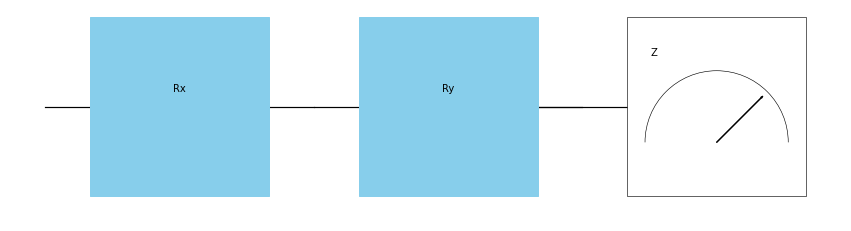

In [3]:
# visualization of the quantum circuit
drawer = qai.matplotlib_drawer(circuit)
drawer.draw_circuit()

# Circuit compiled with pytorch backend

Gradient will obtain from backpropagation by default

### state vector propagation mode

In [4]:
# my_compilecircuit = circuit.compilecircuit(backend="pytorch")

### tensor network contraction mode

#### Use CoTenGra

In [5]:
# slicing_opts = {'target_size': 2**28}
# hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'progbar':True, 'minimize':'flops', 'parallel':True, 'slicing_opts':slicing_opts}
# import cotengra as ctg
# my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_cotengra=ctg, hyper_opt = hyper_opt)

#### Use JDtensorPath (Suggested)
1. 'target_num_slices' is useful if you want to do the contraction in parallel, it will devide the tensor network into pieces and then calculat them in parallel
2. 'math_repeats' means how many times are going to run JDtensorPath to find a best contraction path
3. 'search_parallel' means to run the JDtensorPath in parallel, True means to use all the CPUs, integer number means to use that number of CPUs


In [6]:
from jdtensorpath import JDOptTN as jdopttn
slicing_opts = {'target_size':2**28, 'repeats':500, 'target_num_slices':None, 'contract_parallel':False}
hyper_opt = {'methods':['kahypar'], 'max_time':120, 'max_repeats':12, 'search_parallel':True, 'slicing_opts':slicing_opts}
my_compilecircuit = circuit.compilecircuit(backend="pytorch", use_jdopttn=jdopttn, hyper_opt = hyper_opt, tn_simplify = False)

log10(flops) of this quantum circuit:   1.079181246051244


2022-08-01 23:45:15,019	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8266


log2(size) before slicing:  2.0000000000360676
log10(flops) before removed:    1.5910646070276129


### Define cost function

In [7]:
def cost(params, weight):
    results = my_compilecircuit(params)
    return weight[0]*results + weight[1] + weight[2]

### Batch executation

In [8]:
# First dimension is the batch size
parameters = torch.rand((5, 2), requires_grad= True)
weights = torch.rand((5, 3), requires_grad= True)

In [9]:
cost(parameters[0], weights[0])

tensor([1.3318], grad_fn=<AddBackward0>)

In [10]:
# Batch executation function
vmap_cost = vmap(cost)

In [11]:
vmap_cost(parameters, weights)

tensor([[1.3318],
        [1.7250],
        [1.2095],
        [1.5843],
        [1.5304]], grad_fn=<AddBackward0>)

### Hessian

In [12]:
hess_cost = hessian(cost)

In [13]:
hess = hess_cost(parameters[0], weights[0])
hess

tensor([[[-0.3692,  0.3159],
         [ 0.3159, -0.3692]]], grad_fn=<ViewBackward0>)

### Batch executation of hessian

In [14]:
batch_hess_cost = vmap(hess_cost)

In [15]:
batch_hess_cost(parameters, weights)

tensor([[[[-0.3692,  0.3159],
          [ 0.3159, -0.3692]]],


        [[[-0.3105,  0.0278],
          [ 0.0278, -0.3105]]],


        [[[-0.0722,  0.1015],
          [ 0.1015, -0.0722]]],


        [[[-0.0551,  0.0076],
          [ 0.0076, -0.0551]]],


        [[[-0.5238,  0.2851],
          [ 0.2851, -0.5238]]]], grad_fn=<ViewBackward0>)